<a href="https://colab.research.google.com/github/bmb319/estrogenprogesteroneHA5HT/blob/main/Estrogen_progesterone_histamine_serotonin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

    (Cortisol lowers progesterone and increases histamine)
    
    Results are given in picograms per milliliter (pg/mL). Normal levels for estradiol are:

    30 to 400 pg/mL for premenopausal women (0.000110129 - 0.00146839 uM)

    0 to 30 pg/mL for postmenopausal women (0 - 0.000110129 uM)

    10 to 50 pg/mL for men (0.00003671 - 0.000183549 uM)
    
    In women with regular menstrual cycles, progesterone levels tend to stay below 0.89 ng/mL (0.0028302 uM) before rising to 1.8-24 ng/mL (0.005724 - 0.07632 uM) during ovulation and the luteal phase. 

    In women who are pregnant, progesterone levels can range from 11-44 ng/mL (0.03498 - 0.13992 uM) during the first trimester, and they continue to rise up to 214 ng/mL (0.68052 uM) before birth. 

    In women approaching menopause, progesterone levels can be sporadic depending on frequency of ovulation. During menopause, progesterone eventually falls below 0.20 ng/mL (0.000636 uM). 

In [ ]:
from scipy.integrate._ivp.common import validate_max_step
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import math 

## --------------------- FUNCTIONS OF ESTROGEN AND PROGESTERONE -------------------------

## Function of progesterone metabolism in cytosol by 5-alpha-reductase. 
def V5ared(b):
  # b is concentration of cytosolic progesterone, a is metabolite production in uM/hour. 
  km =  1.93 #$
  vmax = 34.40 #$
  a = (vmax * b)/(km + b)
  return a

## Function of E2 <-> E1 (estrone) in cytosol by 17beta OH-dehydrogenase.
def V17betaHSD1(b, c):
  # b is concentration of E2, c is the concentration of E1. 
  km1 = 1 #$
  km2 = 3.5 #uM 
  vmax_f = 1 #$
  vmax_b = 1 #$
  a =  (vmax_f * b/km1 - vmax_b*c/km2)/(1 + b/km1 + c/km1)
  return a

## Function of E1 (estrone) -> E3 (estriol) in cytosol by P450 cytokines (enzymes). 
def VP450_3A5(b):
  # b is concentration of cytosolic estrone. a is product speed production in uM/hour. 
  km =  1 #$
  vmax = 1 #$
  a = (vmax * b)/(km + b)
  return a

## Function of E1 (estrone) -> catecholestrogens production in cytosol by Catechol-O-methyltransferase (COMT)
def VCOMT(b):
  #b is concentration of cytosolic estrone. a is product speed production in uM/hour. 
  km =  1 #$
  vmax = 1 #$
  a = (vmax * b)/(km + b)
  return a
## Function of cholesterol -> pregnenolone production by P450scc enzyme. 
def VP450scc (b):
  # b is concentration of cytosolic cholesterol. a is product speed production in uM/hour. 
  km =  1 #$
  vmax = 1 #$
  a = (vmax * b)/(km + b)
  return a

## Function of pregnenolone -> progesterone production by 3-beta-HSD enzyme. 
def V3betaHSD(b):
  # b is concentration of cytosolic pregnenolone. a is product speed production in uM/hour. 
  km =  1 #$
  vmax = 1 #$
  a = (vmax * b)/(km + b)
  return a

## Function of pregnenolone -> androstenedione production by CYP 17 enzyme. 
def VCYP17(b):
  # b is concentration of cytosolic pregnenolone. a is product speed production in uM/hour. 
  km =  1 #$
  vmax = 1 #$
  a = (vmax * b)/(km + b)
  return a

## Function of androstenedione <-> testosterone in cytosol by 17beta OH-dehydrogenase.
def V17betaHSD2(b, c):
  # b is concentration of androstenedione, c is the concentration of testosterone. 
  km1 = 1 #$
  km2 = 3.5 #uM 
  vmax_f = 1 #$
  vmax_b = 1 #$
  a =  (vmax_f * b/km1 - vmax_b*c/km2)/(1 + b/km1 + c/km1)
  return a

##Function of androstenedione -> E1 (estrone) in cytosol by CYP19. 
def VCYP19_1(b):
  # b is concentration of cytosolic androstenedione. a is product speed production in uM/hour. 
  km =  1 #$
  vmax = 1 #$
  a = (vmax * b)/(km + b)
  return a

##Function of testosterone -> E2 (estradiol) in cytosol by CYP19. 
def VCYP19_2(b):
  # b is concentration of cytosolic testosterone. a is product speed production in uM/hour. 
  km =  1 #$
  vmax = 1 #$
  a = (vmax * b)/(km + b)
  return a


## Function of E2 bound activation of progesterone synthesis. 
# a is ratio of activation, a = 1 when bound_ce2 = basal_bound_ce2.
def activ_E2_to_prog(bound_ce2, basal_bound_ce2):
  c = 2 #Amplitude of activation of synthesis. 
  b = 1 # Strength of increase.
  a = c/(1 + np.exp(-b * (bound_ce2 - basal_bound_ce2))) 
  return a











## --------------------- FUNCTIONS OF HISTAMINE MODEL -------------------------


## Function of histamine inhibition of synthesis of histamine.
#autoreceptors and depends on levels of g-coupled proteins activated (b) by
#histamine and basal levels of g-coupled histamine (c). 
# Units in uM. 
def inhibsynHAtoHA(b, c):
  a = 1 - (1)*(b - c)
  return a

## Function of histidine decarboxylase
# Histamine synthesis in cytosol.
# UNITS in uM/h. 
def VHTDC(b):
  # b = cht
  #  c = G*
  km = 270 
  vmax = 234
  a =  vmax*(b/(km + b))
  return a

## Function of monoamine transporter in vesicles.
# Transport of histamine from cytosol to vesicles
# b = cha
# c = vha
def VMATH(b, c):
  km = 24        
  vmax =  10552
  a = (vmax*(b/(km + b)) - 5.*c)
  return a


## Function of histamine methyltransferase, 
# Histamine metabolisis in cytosol.
# UNITS in uM/h. 
# b = cha
def VHNMT(b):
  km = 4.2
  vmax = 185.5 
  a = vmax*b/(km + b)
  return a

## Function of  the putative HA transporter in HA neuron. 
# UNITS in uM/h. 
# b = eha
def  VHAT(b):
  km = 10       
  vmax = 4128.3        
  a = vmax*(b/(km + b));
  return a



## Function of histidine transporter. 
# Histidine transport from blood to cytosol.
# UNITS in uM/h. 
# b = bht.
def VHTL(b):
  km = 1000
  vmax = 4680
  a = vmax*(b/(km + b))
  return a

## Function of histidine concentration in blood. 
# Units in uM. 
def HTin(t):
  return 636.55695

## Function of histamine inhibition of histamine firing.
# Dependent on Serotonin-activated g-protein (b) and the  equilibrium  value
# of  the  activated  G-protein (c).
# Units in uM. 
def inhibRHAtoHA(b, c):
  #b = gstar
  a = 1 - (3.5)*(b - c)     
  return a


## Histamine firing function. 
# Units in events/h.
def fireha(t):
  f = 1
  r = 12.5
  rest = 0
  t_start = 5 + rest
  t_stop = 7 + rest
  basal = 1
  b = 2 
  time = t*3600
  if time < t_start:
      f = basal
  elif time > t_start and time < t_stop:
      f = basal + r*(1 - np.exp(-b*(time - t_start)))     
  else:
      f = basal + r*(np.exp(-b*(time - t_stop)) - np.exp(-b*time))
  return f


In [ ]:
def comp_model(z, t):
    # Constants. 
    k_pe = 1 #Constant of progesterone effect to E2. hour^-1
    khaha = 1 #Constant of histamine effects on histamine.hour^-1
    k5ht5ht = 1 #Constant of serotonin effects on serotonin. hour^-1
    k_bp_ep = 1 #Constant of blood progesterone diffusion to extracellular progesterone. hour^-1
    k_ep_removal = 1 #Constant of extracellular progesterone removal away from the synapse. hour^-1
    k_ep_cp = 1 #Constant of diffusion of progesterone from extracellular space to cytosol. hour^-1
    k_be2_ee2 = 1 #Constant of diffusion of blood E2 to extracellular E2. hour^-1
    k_ee2_ce2 = 1 #Constant of diffusion of E2 from extracellular space to cytosol. hour^-1
    k_ee2_removal = 1 #Constant of removal of extracellular E2 to somewhere else. 
    k_be1_ee1 = 1 #Constant of diffusion of blood E1 to extracellular E1. hour^-1
    k_ee1_ce1 = 1 #Constant of diffusion of E1 from extracellular space to cytosol. hour^-1
    k_ee1_removal = 1 #Constant of removal of extracellular E1 to somewhere else.  hour^-1
    k_be3_ee3 = 1 #Constant of diffusion of E3 from blood to extracellular space. hour^-1
    k_ee3_ce3 = 1 #Constant of diffusion of E3 from extracellular space to cytosol. hour^-1 
    k_ee3_removal = 1 #Constant of removal of extracellular E3 to somewhere else. hour^-1
    k_bch_ech = 1 #Constant of diffusion of cholesterol from blood to extracellular space. hour^-1
    k_ech_cch = 1 #Constant of diffusion of cholesterol from extracellular space to cytosol. hour^-1
    k_ch_removal = 1 #Constant of removal of extracellular cholesterol to somewhere else. hour^-1
    k_bpreg_epreg = 1 #Constant of diffusion of pregnenolone from blood to extracellular space. hour^-1
    k_epreg_cpreg = 1 #Constant of diffusion of pregnenolone from extracellular space to cytosol. hour^-1
    k_preg_removal = 1 #Constant of removal of extracellular pregnenolone to somewhere else. hour^-1
    k_bandro_eandro = 1 #Constant of diffusion of androstenedione from blood to extracellular space. hour^-1
    k_eandro_candro = 1 #Constant of diffusion of androstenedione from extracellular space to cytosol. hour^-1 
    k_andro_removal = 1 #Constant of removal of extracellular androstenedione to somewhere else. hour^-1
    k_btest_etest = 1 #Constant of diffusion of testosterone from blood to extracellular space. hour^-1
    k_etest_ctest = 1 #Constant of diffusion of testosterone from extracellular space to cytosol. hour^-1 
    k_test_removal = 1 #Constant of removal of extracellular testosterone to somewhere else. hour^-1 
    k_ce2_ce2bound = 0.1 #Constant of cytosol E2 binding to ER2 alpha receptor.  hour^-1
    k_ce2bound_ce2 = 0.1 #Constant of bound cytosol E2 to free cytosol E2.  hour^-1



    # z-initial conditions and variables of differential equations. 
    #Concentration values. 
    bp = 1000 # Blood progesterone. uM $
    be2 = 1000 #Blood E2.  uM. $ 
    be1 = 1000 #Blood E1. uM. $ 
    be3 = 10 # Blood E3. uM. $
    bch = 100 #Blood cholesterol. uM $ 
    bpreg = 100 #Blood pregnenolone. uM $
    bandro = 100 #Blood androstenedione in uM. $ 
    btest = 100 #Blood testosterone in uM. $ 
    basal_bound_ce2 = 1 #Basal bound cytosolic E2 to ER alpha. uM. 

    ce2 = z[0] #Cytosolic E2. $
    ee2 = z[1] #Extracellular E2. (250 pg/ml)
    ce1 = z[2] #Cytosolic E1. $
    ee1 = z[3] #Extracellular E1. (110 pg/ml)
    ce3 = z[4] #Extracellular E3. (9 pg/ml)
    ee3 = z[5] #Cytosolic E3. $
    cp = z[6] #Cytosolic progesterone in uM. $
    ep = z[7] # Extracellular progesterone in uM. $
    ech = z[8] # Extracellular cholesterol in uM. $ 
    cch = z[9] # Cytosolic cholesterol in uM. $ 
    epreg = z[10] # Extracellular pregnenolone in uM. $
    cpreg = z[11] # Cytosolic pregnenolone in uM. $
    eandro = z[12] #Extracellular androstenedione in uM. $
    candro = z[13] #Cytosolic androstenedione in uM. $
    etest = z[14] #Extracellular testosterone in uM. $
    ctest = z[15] #Cytosolic testosterone in uM. $
    ce2_eralpha_bound = z[16] #Bound E2 to ER-alpha receptors in the nucleus of neurons in uM. $ 


    #Equations
    dce2 = k_pe*cp + k_ee2_ce2 * (ee2 - ce2) - V17betaHSD1(ce2, ce1) + VCYP19_2(ctest) - k_ce2_ce2bound * ce2 + k_ce2bound_ce2 * ce2_eralpha_bound

    dee2 = k_be2_ee2 * (be2 - ee2) - k_ee2_ce2 * (ee2 - ce2) - k_ee2_removal * ee2

    dce1 = k_ee1_ce1 * (ee1 - ce1) + V17betaHSD1(ce2, ce1) - VP450_3A5(ce1) - VCOMT(ce3) + VCYP19_1(candro)

    dee1 = k_be1_ee1 * (be1 - ee1) - k_ee1_ce1 * (ee1 - ce1) - k_ee1_removal * ee1

    dce3 = k_ee3_ce3 * (ee3 - ce3) + VP450_3A5(ce1) 

    dee3 = k_be3_ee3 * (be3 - ee3) - k_ee3_ce3 * (ee3 - ce3) - k_ee3_removal * ee3

    dcp = k_ep_cp * (ep - cp) - V5ared(cp) + activ_E2_to_prog(ce2_eralpha_bound, basal_bound_ce2) * V3betaHSD(cpreg)

    dep = k_bp_ep * (bp - ep) - k_ep_cp * (ep - cp) - k_ep_removal * ep

    dech = k_bch_ech * (bch - ech) - k_ech_cch * (ech - cch) - k_ch_removal * ech

    dcch = k_ech_cch * (ech - cch) - VP450scc(cch)

    depreg = k_bpreg_epreg * (bpreg - epreg) - k_epreg_cpreg * (epreg - cpreg) - k_preg_removal * epreg

    dcpreg = k_epreg_cpreg * (epreg - cpreg) + VP450scc(cch) - activ_E2_to_prog(ce2_eralpha_bound, basal_bound_ce2) * V3betaHSD(cpreg)

    deandro = k_bandro_eandro * (bandro - eandro) - k_eandro_candro * (eandro - candro) - k_andro_removal * eandro

    dcandro = k_eandro_candro * (eandro - candro) + VCYP17(cpreg) - V17betaHSD2(candro, ctest) - VCYP19_1(candro)

    detest = k_btest_etest * (btest - etest) - k_etest_ctest * (etest - ctest) - k_test_removal * etest

    dctest = k_etest_ctest * (etest - ctest) + V17betaHSD2(candro, ctest) - VCYP19_2(ctest)

    dce2_eralpha_bound = k_ce2_ce2bound * ce2 - k_ce2bound_ce2 * ce2_eralpha_bound 


    ## Histamine model. 
    b1 = 15  #HA leakage from the cytosol to the extracellular space. 
    b2 = 3.5  #HA release per action potential. 
    b4 = 0.05  #HA removal from the extracellular space
    b5 = .25  #Strength of stabilization of blood HT near 100μM. 
    b6 = 2.5 #From cHT to HTpool.
    b7 = 1 #From HTpool to cHT. 
    b8 = 1 #Other uses of HT remove HT. 
    c9 = 100 #Bound autoreceptors produceG∗. 
    c10 = 961.094 #T∗ facilitates the reversion of G∗ to G. 
    c11 = 20 #G∗ produces T∗. 
    c12 = 66.2992 #decay coefficient of T∗
    c13 = 0.5*10  #eHA binds to autoreceptors. 
    c14 = 0.5*131.23578 #eHA dissociates from autoreceptors
    g0HH = 10  #Total gstar for H3 on HA neuron
    t0HH = 10 #Total tstar for H3 on HA neuron
    b0HH = 10  #Total H3 receptors on HA neuron


    #Steady state values. 
    gstar_ha_basal =  0.7484 #Equilibrium concentration of g* histamine.
    bht0 = 100 #Steady state value of blood histidine. 

    cha = z[17]
    vha = z[18]
    eha = z[19]
    bht = z[20]
    cht = z[21]
    chtpool = z[22]
    gstar = z[23]
    tstar = z[24]
    bound = z[25] 


    dcha = inhibsynHAtoHA(gstar, gstar_ha_basal) * VHTDC(cht)  - VMATH(cha, vha) -  VHNMT(cha) - b1*(cha - eha) + VHAT(eha)
    dvha = VMATH(cha, vha) - inhibRHAtoHA(gstar, gstar_ha_basal)*fireha(t)*b2*vha
    deha = inhibRHAtoHA(gstar, gstar_ha_basal)*fireha(t)*b2*vha - VHAT(eha) + b1*(cha - eha)  - b4*eha
    dbht = HTin(t) - VHTL(bht)  - b5*(bht - bht0)
    dcht = VHTL(bht) - inhibsynHAtoHA(gstar, gstar_ha_basal) * VHTDC(cht) - b6*cht + b7*chtpool
    dchtpool = b6*cht - b7*chtpool - b8*chtpool
    dgstar  = c9*bound**2*(g0HH - gstar) - c10*tstar*gstar
    dtstar = c11*gstar**2*(t0HH - tstar)  - c12*tstar
    dbound = c13*eha*(b0HH - bound)  - c14*bound


    return [dce2, dee2, dce1, dee1, dce3, dee3, dcp, dep, dech, dcch, depreg, dcpreg, deandro, dcandro, detest, dctest, dce2_eralpha_bound, dcha, dvha, deha, dbht,  dcht, dchtpool, dgstar, dtstar, dbound]


Text(0, 0.5, 'HA concentration (uM)')

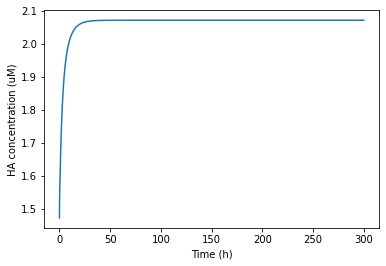

In [ ]:

#the equations model the differential terms of this model, calculate how much these variables are going to change in each iterations
#find the ks that give the diff eq to 0

#Time array.
t_factor = 1 # Time factor for graphs.
time = 300/t_factor # Time of simulation depending on t_factor.
sampling_rate = 10*t_factor #number of samples per time factor units.
time_array = np.linspace(0, time, math.floor(time * sampling_rate + 1))



#Initial conditions
z0 = [0.00073, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3.1968, 140.3708, 1.4717,  100, 250, 300, 0.7221, 1.3593, 1.0084] #value at time zero SUBSTITUTE THE 1's. 
#Constant parameters for steady state
 
#buscar valores que tengan sentido y evidentemente sea positive


#Get solution of the differential equation.
x = odeint(comp_model, z0, time_array) #shows how the steady state values have changed over time


plt.figure()
plt.plot(time_array, x[:, 19])
plt.xlabel('Time (h)')
plt.ylabel('HA concentration (uM)')

**Next Steps: **

1. How progesterone affects estrogen. 

3. Look how progesterone affects serotonin and histamine. 
